In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')


In [2]:
mercado_df = pd.read_csv("C://Flavio/Projeto Otimizacao/Modelo Mercado/data_consolidado_final_jun24.csv",
                     encoding='latin-1',
                     delimiter=';')

In [3]:
df_mod=mercado_df[["premio_total_liq_cap","ano_mod_conv","classe_bonus",
                   "idade","is_casco","is_dmoral","is_rcdc","is_rcdm",
                   "RNS_Casco_calc",
                   "Grupo_veiculo_new", "fabrica","idade_ult_RNS","md_categoria",
                   "MD_comb","md_config","MD_franquia","md_menor26","md_sexo",
                   "MD_Subzona","md_tipo_renov","MD_uso_veic","uf"]]

df_mod.rename(columns={'premio_total_liq_cap':'premio_ofertado', 'ano_mod_conv': 'ano_mod'},inplace=True)

In [4]:
x_df_num = df_mod[['ano_mod', 'classe_bonus', 'idade', 'is_casco', 'is_dmoral', 'is_rcdc', 'is_rcdm', 'RNS_Casco_calc']]
x_df_cat = df_mod[['Grupo_veiculo_new', 'fabrica', 'idade_ult_RNS', 'md_categoria', 'MD_comb', 'md_config', 'MD_franquia', 'md_menor26', 'md_sexo', 'MD_Subzona','md_tipo_renov', 'MD_uso_veic','uf']]
y   = df_mod[['premio_ofertado']]
x_df_dummy=pd.get_dummies(x_df_cat)
x_df=pd.concat([x_df_num, x_df_dummy],axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_df, y, test_size=0.15) 

In [7]:
import lightgbm as lgb
params = {
    'task': 'train', 
    'boosting': 'gbdt',
    'objective': 'regression',
    'num_leaves': 10,
    'learnnig_rage': 0.05,
    'metric': {'l2','l1'},
    'verbose': -1
}

lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval  = lgb.Dataset(x_test, y_test, reference=lgb_train)

model_gbm = lgb.train(params,
                 train_set=lgb_train,
                 valid_sets=lgb_eval)

y_pred = model_gbm.predict(x_test, predict_disable_shape_check=True)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse) 

MSE: 580539.45
RMSE: 761.93


## modelagem GLM

In [8]:
df_mod_mp_feb23may24_v3 = pd.read_csv("C://Flavio/Projeto Otimizacao/Modelo Renovacao/df_mod_mp_feb23may24_v3.csv",
                     encoding='latin-1',
                     delimiter='|')

parte para incluir o preço do mercado na base de modelagem glm

In [9]:
colunas=['premio_ofertado','ano_mod','classe_bonus','MD_idade','is_casco_ofer','is_dmoral','is_rcdc','is_rcdm','RNS_Casco_calc',
 'Grupo_veiculo_new','FABRICA','idade_ult_RNS', 'md_categoria','MD_comb','MD_config','MD_franquia','MD_menor26','MD_sexo','MD_Subzona',  
 'MD_tipo_renov','MD_uso_veic','UF']

In [10]:
df_escorar_gbm=df_mod_mp_feb23may24_v3[colunas]

In [11]:
df_escorar_gbm.rename(columns={'MD_idade':'idade', 
                                   'is_casco_ofer': 'is_casco',
                                   'FABRICA': 'fabrica',
                                   'MD_config':  'md_config',
                                   'MD_menor26': 'md_menor26',
                                   'MD_sexo': 'md_sexo',
                                   'UF': 'uf',
                                   'MD_tipo_renov':  'md_tipo_renov'},inplace=True)
df_escorar_gbm['idade'] = pd.to_numeric(df_escorar_gbm['idade'], errors='coerce')

In [13]:
df_num = df_escorar_gbm[['ano_mod', 'classe_bonus', 'idade', 'is_casco', 'is_dmoral', 'is_rcdc', 'is_rcdm', 'RNS_Casco_calc']]
df_cat = df_escorar_gbm[['Grupo_veiculo_new', 'fabrica', 'idade_ult_RNS', 'md_categoria', 'MD_comb', 'md_config', 'MD_franquia', 'md_menor26', 'md_sexo', 'MD_Subzona','md_tipo_renov', 'MD_uso_veic','uf']]
df_cat_glm=pd.get_dummies(df_cat)
df_cat_glm=pd.concat([df_num, df_cat_glm],axis=1)
GBM_mercado = model_gbm.predict(df_cat_glm, predict_disable_shape_check=True)

In [14]:
import numpy as np
np.average(GBM_mercado)

4106.275672356089

In [16]:
df_mod_mp_feb23may24_v3['GBM_mercado']=GBM_mercado

#### prepara base de modelagem glm

In [43]:
df_mod_filtered=df_mod_mp_feb23may24_v3[["premio_ofertado","premio_total",'GBM_mercado', 'premio_creserva','premio_demais_cob',"teste_validacao","ind_renovacao","classe_bonus","MD_sexo","cod_corr",
                                "Cod_End","MD_sin_5a_cas","MD_tempo_casa_2","MD_idade_veic","MD_faixa_IScas",
                                "anomes_dt_ter" ,"MD_idade" ,"per_com", "RNS_Casco_calc","MD_menor26","UF","Renovacao_ant",
                                "fx_ir_12m","is_casco_ofer","classe_bonus","MD_fator_ajuste","MD_capac","md_categoria",
                                "MD_comb","MD_qtd_assis_cpf", "idade_ult_RNS","canal","MD_tipo_renov",'FABRICA','MD_est_civil',
                                'peso','Grupo_veiculo_new','vigencia',
                                'Risco_PP_mod', 'Risco_PT_mod','Risco_RF_mod','Risco_DM_mod','Risco_AS_mod',
                                'Risco_DC_mod' ,'Risco_DMO_mod']]

In [44]:
df_mod_filtered = df_mod_filtered[df_mod_filtered['per_com'].notna()]
df_mod_filtered = df_mod_filtered[df_mod_filtered['Renovacao_ant'].notna()]
df_mod_filtered = df_mod_filtered[df_mod_filtered['MD_est_civil'].notna()]
df_mod_filtered = df_mod_filtered[df_mod_filtered['peso'].notna()]
df_mod_filtered = df_mod_filtered[~df_mod_filtered['anomes_dt_ter'].isin([202310,202309,202308,202302,202402])]
df_mod_filtered = df_mod_filtered.query('vigencia == "Anual"')
df_mod_filtered = df_mod_filtered[(df_mod_filtered['per_com']>0) & (df_mod_filtered['per_com']<50)]
df_mod_filtered = df_mod_filtered.query('premio_total >100')
df_mod_filtered = df_mod_filtered.query('premio_creserva >= 0')
df_mod_filtered = df_mod_filtered.query('is_casco_ofer > 0')
df_mod_filtered.shape

(388318, 45)

In [45]:
df_mod_filtered['DA_emissao'] =0.2349
df_mod_filtered['DA_producao'] =0.2749
df_mod_filtered['risco_dmais_cob'] =df_mod_filtered['premio_demais_cob']*0.2627*1.4
df_mod_filtered['premio_anterior'] =df_mod_filtered['premio_total']
df_mod_filtered['Act_cost']  = df_mod_filtered['Risco_PP_mod'] + df_mod_filtered['Risco_PT_mod'] + df_mod_filtered['Risco_RF_mod']+ df_mod_filtered['Risco_DM_mod']+ df_mod_filtered['Risco_AS_mod'] + df_mod_filtered['Risco_DC_mod'] +df_mod_filtered['Risco_DMO_mod'] + df_mod_filtered['risco_dmais_cob']
df_mod_filtered['Premio_IC100']  = df_mod_filtered['Act_cost']/(1-df_mod_filtered['per_com']/100-df_mod_filtered['DA_producao'] )
df_mod_filtered["premio"] = df_mod_filtered["premio_ofertado"]

In [46]:
df_mod=df_mod_filtered.copy()

In [47]:
#Criar um função para categorizar 

df_mod['MD_sexo_bin'] = df_mod['MD_sexo'].map({'Masculino': 'Masculino', 
                                 'Feminino': 'Feminino', 
                                  'ERRO': 'Masculino'}).astype(object)

df_mod['fx_ir_12m_bin'] = df_mod['fx_ir_12m'].apply(lambda x: '01 - 00-<=020' if x == '01 - 00-<=020' else
                                                              '02 - 20-<=040' if x == '02 - 20-<=040' else
                                                              '03 - 40-<=060' if x == '03 - 40-<=060' else
                                                              '04 - 60-<=080' if x == '04 - 60-<=080' else
                                                              '05 - 80-<=100' if x == '05 - 80-<=100' else
                                                              '02 - 20-<=040' if x == 'NI'           else 'ERROR')
   
df_mod['per_com_bin'] = df_mod['per_com'].apply(lambda x: '<10' if x < 10 else
                                                          '>=10' if x >= 10 else 'ERROR')     
  
df_mod['MD_comb_bin'] = df_mod['MD_comb'].apply(lambda x: 'Gasolina' if x == 'Gasolina'  else 'Demais')

df_mod['canal_bin'] = df_mod['canal'].apply(lambda x: 'Corretor Mais' if x == 'Corretor Mais'  else 'Demais')

df_mod['idade_ult_RNS_bin'] = df_mod['idade_ult_RNS'].apply(lambda x: 'Sem Sinistro' if x == 'Sem Sinistro' else
                                                                      '01 ano' if x == '01 ano' else
                                                                      '02 ano' if x == '02 ano' else '02 ano +')

df_mod['UF_bin'] = df_mod['UF'].apply(lambda x: 'AL,CE,RS'  if x == 'AL' else
                                                'AL,CE,RS'  if x == 'CE' else
                                                'AL,CE,RS'  if x == 'RS' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'AP' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'DF' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'ES' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PA' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PB' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'RN' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'SC' else 
                                                'GO,MA,MG'             if x == 'GO' else 
                                                'GO,MA,MG'             if x == 'MA' else 
                                                'GO,MA,MG'             if x == 'MG' else 
                                                'MT,PR'                if x == 'MT' else
                                                'MT,PR'                if x == 'PR' else 
                                                'RJ'                   if x == 'RJ' else  'Demais')



df_mod['md_tipo_renov_ant_bin'] = df_mod['Renovacao_ant'].apply(lambda x: '1-SeguroNovo'                      if x == '1-Seguro Novo'    else
                                                                          '2 - Renov MAPFRE sem sinistro'     if x == '2-RenovPropria'   else
                                                                          '3 - Renov MAPFRE com sinistro'     if x == '2-RenovPropria'   else
                                                                          '4 - Renov Congenere sem sinistro'  if x == '3-RenovCongenere' else
                                                                          '5 - Renov Congenere com sinistro'  if x == '3-RenovCongenere' else
                                                                          '6 - Renov BB sem sinistro'         if x == '3-RenovCongenere' else
                                                                          '7 - Renov BB com sinistro'         if x == '3-RenovCongenere' else  '2-RenovPropria')
      
      

    
df_mod['Cod_End_bin'] = df_mod['Cod_End'].apply(lambda x: '13509'  if x == 13509 else
                                                          '13509'  if x == 50007 else
                                                          '13509'  if x == 50100 else 'Demais')   

df_mod['MD_capac_bin'] = df_mod['MD_capac'].apply(lambda x: '5'  if x == 5  else 'Demais')  



df_mod['fator_ajuste_bin'] = df_mod['MD_fator_ajuste'].apply(lambda x: '<101'    if x < 101 else
                                                                       '>=101'   if x >= 101  else '<101')   

df_mod['MD_qtd_assis_cpf_bin'] = df_mod['MD_qtd_assis_cpf'].apply(lambda x: '00'  if x == 0 else
                                                                            '01'  if x == 1 else
                                                                            '>=2' if x >= 2 else 'ERROR')

In [48]:
df_train = df_mod.query('teste_validacao == "Trein"')
df_train.shape

(310913, 64)

In [36]:
#df_train2 = df_train[df_train[(df_train['UF'] == 'SP')] & (~df_train['Grupo_veiculo_new'].isin(["Toyota Hilux CD","Toyota Hilux CS","Toyota Hilux SW4"]))]
#df_train2.shape

In [496]:
#df_train = df_train[(df_train['UF'] == 'SP') & (~df_train['Grupo_veiculo_new'].isin(["Toyota Hilux CD","Toyota Hilux CS","Toyota Hilux SW4"]))]
#df_train.shape

In [49]:
display(df_train[["Act_cost", "Premio_IC100", "per_com","ind_renovacao",'GBM_mercado']].describe().T)

,count,mean,std,min,25%,50%,75%,max
Act_cost,310913.0,1723.935999,1533.558565,155.790548,880.102121,1287.055629,2035.829042,74027.191185
Premio_IC100,310913.0,3024.359106,2669.004613,312.305413,1555.405520,2256.816147,3576.591487,124394.540725
per_com,310913.0,15.434452,5.672286,1.000000,10.000000,15.000000,20.000000,49.000000
ind_renovacao,310913.0,0.464191,0.498717,0.000000,0.000000,0.000000,1.000000,1.000000
GBM_mercado,310913.0,4116.566993,1060.687649,2103.220000,3376.541054,3897.500791,4635.279464,10696.172316


In [161]:
#df_train.columns.to_list()

In [52]:
import statsmodels.formula.api as smf
#Modelo GLM de retenção
formula = 'ind_renovacao ~ 1 + np.log(premio) + np.divide(premio, is_casco_ofer) + np.log(np.divide(premio, GBM_mercado)) + np.log(np.divide(premio, Premio_IC100)) + (np.divide(premio, premio_anterior)+1) + C(canal_bin,Treatment(reference="Demais")) + C(Cod_End_bin,Treatment(reference="Demais")) + C(fator_ajuste_bin,Treatment(reference="<101")) + per_com + C(per_com_bin,Treatment(reference=">=10")) + np.log(MD_tempo_casa_2+1) + C(idade_ult_RNS_bin,Treatment(reference="Sem Sinistro")) + C(MD_comb_bin,Treatment(reference="Demais")) + C(UF_bin,Treatment(reference="Demais")) + C(fx_ir_12m_bin,Treatment(reference="02 - 20-<=040")) + C(MD_tipo_renov,Treatment(reference="2 - Renov MAPFRE sem sinistro"))' 
model = smf.logit(formula , data=df_train).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.564789
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          ind_renovacao   No. Observations:               310913
Model:                          Logit   Df Residuals:                   310888
Method:                           MLE   Df Model:                           24
Date:                Thu, 25 Jul 2024   Pseudo R-squ.:                  0.1822
Time:                        11:32:57   Log-Likelihood:            -1.7560e+05
converged:                       True   LL-Null:                   -2.1471e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
===========================================================================================================================================================================
                                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                   2.2112      0.210     10.532      0.000       1.800       2.623
C(canal_bin, Treatment(reference="Demais"))[T.Corretor Mais]                                                0.0324      0.010      3.150      0.002       0.012       0.053
C(Cod_End_bin, Treatment(reference="Demais"))[T.13509]                                                     -0.2789      0.014    -20.416      0.000      -0.306      -0.252
C(fator_ajuste_bin, Treatment(reference="<101"))[T.>=101]                                                   0.0802      0.029      2.774      0.006       0.024       0.137
C(per_com_bin, Treatment(reference=">=10"))[T.<10]                                                          0.1797      0.024      7.467      0.000       0.133       0.227
C(idade_ult_RNS_bin, Treatment(reference="Sem Sinistro"))[T.01 ano]                                        -0.5223      0.024    -21.392      0.000      -0.570      -0.474
C(idade_ult_RNS_bin, Treatment(reference="Sem Sinistro"))[T.02 ano +]                                      -0.4709      0.012    -37.809      0.000      -0.495      -0.446
C(MD_comb_bin, Treatment(reference="Demais"))[T.Gasolina]                                                   0.3811      0.019     19.914      0.000       0.344       0.419
C(UF_bin, Treatment(reference="Demais"))[T.AL,CE,RS]                                                       -0.2144      0.013    -15.897      0.000      -0.241      -0.188
C(UF_bin, Treatment(reference="Demais"))[T.AP,DF,ES,PA,PB,RN,SC]                                           -0.2300      0.014    -16.606      0.000      -0.257      -0.203
C(UF_bin, Treatment(reference="Demais"))[T.GO,MA,MG]                                                       -0.0658      0.015     -4.461      0.000      -0.095      -0.037
C(UF_bin, Treatment(reference="Demais"))[T.MT,PR]                                                          -0.1027      0.014     -7.287      0.000      -0.130      -0.075
C(UF_bin, Treatment(reference="Demais"))[T.RJ]                                                              0.3069      0.020     14.984      0.000       0.267       0.347
C(fx_ir_12m_bin, Treatment(reference="02 - 20-<=040"))[T.01 - 00-<=020]                                    -0.9160      0.017    -52.619      0.000      -0.950      -0.882
C(fx_ir_12m_bin, Treatment(reference="02 - 20-<=040"))[T.03 - 40-<=060]                                     0.4855      0.010     48.799      0.000       0.466       0.505
C(fx_ir_12m_bin, Treatment(reference="02 - 20-<=040"))[T.04 - 60-<=080]                                     1.1634      0.013     86.383      0.0

## Base Para escorar e otimizar

In [188]:
df_lote_092024 = pd.read_csv("C://Flavio/Projeto Otimizacao/Otimizacao/Table Base Case Total  - modelo novo.csv",
                     encoding='latin-1',
                     delimiter='|')

In [189]:
df_lote_092024['GBM_mercado'].describe()

count    27304.000000
mean      2662.428740
std       1406.693218
min       1015.431214
25%       1797.549029
50%       2284.675931
75%       3005.559169
max      13353.547185
Name: GBM_mercado, dtype: float64

In [190]:
df_lote_escorar=df_lote_092024.copy()

In [192]:
#df_lote_escorar.columns.to_list()

In [68]:
#df_lote_092024.columns.to_list()

df_lote_escorar=df_lote_092024[['Premio_oferecido_com_batente','Pr_anterior_TI','Premio_IC100','GBM_mercado',
                                          'Classe_bonus',"MD_sexo","cod_corr","cod_end","MD_tempo_casa_2",
                                          "per_com", "MD_menor26","UF","Renovacao_ant","fx_ir_12m","is_casco_ofer",
                                          "MD_fator_ajuste","md_capac","MD_categoria",
                                          "MD_comb","MD_qtd_assis_cpf", "idade_ult_RNS","canal","MD_tipo_renov",'FABRICA',
                                          'MD_est_civil','Grupo_veiculo_new']]

In [193]:
df_lote_escorar.columns

Index(['Act_cost', 'Amostra', 'Amostra_inicial', 'ano_fab', 'ano_modelo',
       'batente_max_ti', 'batente_min_ti', 'canal', 'Carprice', 'chave',
       ...
       'Taxa Prêmio/IS', 'Taxa Prêmio/Risco', 'Taxa Risco/IS (casco)',
       'TIPO_RENOV', 'Total Earnings NPV', 'UF', 'Uniforme',
       'valida_sistema_elast_max', 'valida_sistema_elast_min', 'vigencia'],
      dtype='object', length=122)

In [153]:
#print(df_lote_escorar['UF'].value_counts(ascending=False))

premio|Premio_oferecido_com_batente
is_casco_ofer|is_casco_ofer
GBM_mercado|GBM_mercado
Premio_IC100|Premio_IC100
premio_anterior|Pr_anterior_TI
canal_bin| canal
Cod_End_bin|  cod_end
fator_ajuste_bin|  MD_fator_ajuste
per_com|per_com
MD_tempo_casa_2|MD_tempo_casa_2
idade_ult_RNS_bin|idade_ult_RNS
MD_comb_bin|MD_comb
UF_bin      |     UF
fx_ir_12m_bin|    fx_ir_12m
MD_tipo_renov,|   MD_tipo_renov

In [98]:
#df_lote_escorar.columns.to_list()

In [194]:
df_lote_escorar["premio"] = df_lote_escorar["Premio_oferecido_com_batente"]

In [195]:
df_lote_escorar.rename(columns={'Pr_anterior_TI':'premio_anterior', 
                                   'cod_end': 'Cod_End',
                                   'md_capac': 'MD_capac',
                                   'fator_ajuste': 'MD_fator_ajuste'},inplace=True)

In [197]:
#df_lote_escorar.columns.to_list()

In [198]:
df_lote_escorar=df_lote_escorar[df_lote_escorar['UF']!= "99"]

In [199]:
df_lote_escorar.shape

(27298, 123)

In [200]:
df_mod = df_lote_escorar.copy()

In [201]:
#Criar um função para categorizar 

df_mod['MD_sexo_bin'] = df_mod['MD_sexo'].map({'Masculino': 'Masculino', 
                                 'Feminino': 'Feminino', 
                                  'ERRO': 'Masculino'}).astype(object)


df_mod['fx_ir_12m_bin'] = df_mod['fx_ir_12m'].apply(lambda x: '01 - 00-<=020' if x == '01 - 00-<=020' else
                                                              '02 - 20-<=040' if x == '02 - 20-<=040' else
                                                              '03 - 40-<=060' if x == '03 - 40-<=060' else
                                                              '04 - 60-<=080' if x == '04 - 60-<=080' else
                                                              '05 - 80-<=100' if x == '05 - 80-<=100' else
                                                              '02 - 20-<=040' if x == 'NI'           else 'ERROR')

  
df_mod['MD_comb_bin'] = df_mod['MD_comb'].apply(lambda x: 'Gasolina' if x == 'Gasolina'  else 'Demais')

df_mod['canal_bin'] = df_mod['canal'].apply(lambda x: 'Corretor Mais' if x == 'Corretor Mais'  else 'Demais')
   
df_mod['per_com_bin'] = df_mod['per_com'].apply(lambda x: '<10' if x < 10 else
                                                          '>=10' if x >= 10 else 'ERROR')    



df_mod['idade_ult_RNS_bin'] = df_mod['idade_ult_RNS'].apply(lambda x: 'Sem Sinistro' if x == 'Sem Sinistro' else
                                                                      '01 ano' if x == '01 ano' else
                                                                      '02 ano' if x == '02 ano' else '02 ano +')




df_mod['UF_bin'] = df_mod['UF'].apply(lambda x: 'AL,CE,RS'  if x == 'AL' else
                                                'AL,CE,RS'  if x == 'CE' else
                                                'AL,CE,RS'  if x == 'RS' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'AP' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'DF' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'ES' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PA' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PB' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'RN' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'SC' else 
                                                'GO,MA,MG'             if x == 'GO' else 
                                                'GO,MA,MG'             if x == 'MA' else 
                                                'GO,MA,MG'             if x == 'MG' else 
                                                'MT,PR'                if x == 'MT' else
                                                'MT,PR'                if x == 'PR' else 
                                                'RJ'                   if x == 'RJ' else  'Demais')

df_mod['md_tipo_renov_ant_bin'] = df_mod['Renovacao_ant'].apply(lambda x: '1-SeguroNovo'                      if x == '1-Seguro Novo'    else
                                                                          '2 - Renov MAPFRE sem sinistro'     if x == '2-RenovPropria'   else
                                                                          '3 - Renov MAPFRE com sinistro'     if x == '2-RenovPropria'   else
                                                                          '4 - Renov Congenere sem sinistro'  if x == '3-RenovCongenere' else
                                                                          '5 - Renov Congenere com sinistro'  if x == '3-RenovCongenere' else
                                                                          '6 - Renov BB sem sinistro'         if x == '3-RenovCongenere' else
                                                                          '7 - Renov BB com sinistro'         if x == '3-RenovCongenere' else  '2-RenovPropria')
      
      

    
df_mod['Cod_End_bin'] = df_mod['Cod_End'].apply(lambda x: '13509'  if x == 13509 else
                                                          '13509'  if x == 50007 else
                                                          '13509'  if x == 50100 else 'Demais')   

df_mod['MD_capac_bin'] = df_mod['MD_capac'].apply(lambda x: '5'  if x == 5  else 'Demais')  



df_mod['fator_ajuste_bin'] = df_mod['MD_fator_ajuste'].apply(lambda x: '<101'    if x < 101 else
                                                                       '>=101'   if x >= 101  else '<101')   

df_mod['MD_qtd_assis_cpf_bin'] = df_mod['MD_qtd_assis_cpf'].apply(lambda x: '00'  if x == 0 else
                                                                            '01'  if x == 1 else
                                                                            '>=2' if x >= 2 else 'ERROR')



In [207]:
#df_mod.columns.to_list()

In [202]:
df_mod["prob_est"]=model.predict(df_mod)
prob_est = model.predict(df_mod)

In [203]:
df_mod["prob_est"].describe()

count    27298.000000
mean         0.472937
std          0.223883
min          0.017370
25%          0.292339
50%          0.466778
75%          0.635730
max          0.991410
Name: prob_est, dtype: float64

In [269]:
#df_lote_092024.columns.to_list()

In [204]:
df_mod[["prob_est",'Renewal Demand']].describe()

,prob_est,Renewal Demand
count,27298.000000,27298.000000
mean,0.472937,0.505496
std,0.223883,0.239074
min,0.017370,0.011015
25%,0.292339,0.310497
50%,0.466778,0.514788
75%,0.635730,0.694137
max,0.991410,0.995868


## Otimização Teste 1

In [589]:
df_otim1 =df_mod[(df_mod["chave"] == 602601397333100001) | (df_mod["chave"] == 179600013563100001)]
#df_otim1 =df_mod[(df_mod["chave"] == 10708289513100001)]
#df_otim1 = df_mod[["chave","Act_cost","premio","prob_est"]]
df_otim1.head()

,Act_cost,Amostra,Amostra_inicial,ano_fab,ano_modelo,batente_max_ti,batente_min_ti,canal,Carprice,chave,...,canal_bin,per_com_bin,idade_ult_RNS_bin,UF_bin,md_tipo_renov_ant_bin,Cod_End_bin,MD_capac_bin,fator_ajuste_bin,MD_qtd_assis_cpf_bin,prob_est
0,1089.960657,Otimização Mkp,Otimização Mkp,2019,2019,2.3,0.6,BancoVotorantim,49491,179600013563100001,...,Demais,>=10,Sem Sinistro,"AP,DF,ES,PA,PB,RN,SC",2-RenovPropria,Demais,NaN,<101,00,0.160808
20003,3248.385166,Teste_+5%,Teste_+5%,2015,2016,2.3,1.3,CorretorMais,47021,602601397333100001,...,Demais,>=10,01 ano,Demais,2-RenovPropria,Demais,NaN,<101,>=2,0.666168


In [510]:
#df_otim1.columns.to_list()

In [574]:
def otimanual (df,renewal_target):

    # Criar vetor de fatores
    fatores = np.arange(1.5, 0.5, -0.05)

    # Criar uma lista para armazenar os novos 
    dataframes = []

    # Loop para criar uma nova coluna prêmio multiplicado por cada fator para cada linha 
    for fator in fatores:
        df_temp = df.copy()
        df_temp['premio'] = df_temp['premio'] * fator
        df_temp['fator'] = fator
        df_temp["prob_est_2"]=model.predict(df_temp)
        df_temp["margem"]= df_temp["prob_est_2"]*(df_temp["premio"]-df_temp["Act_cost"])
        dataframes.append(df_temp)

    # Concatenar todos os dataframes em um único dataframe 
    df_resultado = pd.concat(dataframes, ignore_index=True)

    df_resultado["LB"]= df_resultado["Premio_oferecido_com_batente"]*0.9
    df_resultado["UB"]= df_resultado["Premio_oferecido_com_batente"]*1.1 

    df_resultado = df_resultado.query('premio >=LB')
    df_resultado = df_resultado.query('premio <=UB')   
    
    df_resultado = df_resultado[df_resultado["prob_est_2"] > renewal_target]

    return df_resultado.sort_values("margem",ascending=False).head(1)
   

In [577]:
def otimanual2(df,renewal_target):
    dataframes = []
    for linha in range(df.shape[0]):
        linha = df.iloc[[linha],:]
        df_linha = otimanual(linha,renewal_target)
        dataframes.append(df_linha)
    df_resultado_final = pd.concat(dataframes, ignore_index=True) 
    return df_resultado_final

In [584]:
%%time
df_resultado_final2 = otimanual2(df_mod[0:1],renewal_target=0.1)
df_resultado_final2

CPU times: total: 234 ms
Wall time: 285 ms


,Act_cost,Amostra,Amostra_inicial,ano_fab,ano_modelo,batente_max_ti,batente_min_ti,canal,Carprice,chave,...,Cod_End_bin,MD_capac_bin,fator_ajuste_bin,MD_qtd_assis_cpf_bin,prob_est,fator,prob_est_2,margem,LB,UB
0,1089.960657,Otimização Mkp,Otimização Mkp,2019,2019,2.3,0.6,BancoVotorantim,49491,179600013563100001,...,Demais,NaN,<101,00,0.160808,0.95,0.183224,150.634705,1811.457,2214.003


In [581]:
display(df_resultado_final[["prob_est","prob_est_2"]].describe().T)

,count,mean,std,min,25%,50%,75%,max
prob_est,2.0,0.413488,0.357344,0.160808,0.287148,0.413488,0.539828,0.666168
prob_est_2,2.0,0.383625,0.283410,0.183224,0.283425,0.383625,0.483826,0.584027


In [411]:
# Exibir o dataframe resultante
#df_resultado.head(20)

In [512]:
df_resultado2 = df_resultado[["chave","Act_cost","Premio_oferecido_com_batente","premio","prob_est","prob_est_2",'fator',"margem","premio_anterior"]]
df_resultado2

,chave,Act_cost,Premio_oferecido_com_batente,premio,prob_est,prob_est_2,fator,margem,premio_anterior
0,10708289513100001,273.190374,437.034672,655.552008,0.745265,0.512058,1.50,195.791150,574.04
1,10708289513100001,273.190374,437.034672,633.700275,0.745265,0.534874,1.45,192.827370,574.04
2,10708289513100001,273.190374,437.034672,611.848541,0.745265,0.558033,1.40,188.982499,574.04
3,10708289513100001,273.190374,437.034672,589.996808,0.745265,0.581459,1.35,184.209966,574.04
4,10708289513100001,273.190374,437.034672,568.145074,0.745265,0.605068,1.30,178.467797,574.04
5,10708289513100001,273.190374,437.034672,546.293340,0.745265,0.628772,1.25,171.719563,574.04
6,10708289513100001,273.190374,437.034672,524.441607,0.745265,0.652476,1.20,163.935285,574.04
7,10708289513100001,273.190374,437.034672,502.589873,0.745265,0.676079,1.15,155.092267,574.04
8,10708289513100001,273.190374,437.034672,480.738140,0.745265,0.699481,1.10,145.175821,574.04
9,10708289513100001,273.190374,437.034672,458.886406,0.745265,0.722578,1.05,134.179868,574.04


In [513]:
max_val = df_resultado.loc[(df_resultado['margem'] == df_resultado['margem'].max())]
print(max_val)

import plotly.graph_objects as go

fig_PriceVsRevenue = go.Figure()

fig_PriceVsRevenue.add_trace(go.Scatter(

x=df_resultado['premio'], y=df_resultado['margem']))

fig_PriceVsRevenue.add_annotation(x=int(max_val['premio']), y=int(max_val['margem']),

 text="Maximum Revenue",

 showarrow=True,

 arrowhead=1)

fig_PriceVsRevenue.update_layout(

 showlegend=False,

 xaxis_title="Premio",

 yaxis_title="Margem")

fig_PriceVsRevenue.add_vline(x=int(max_val['premio']), line_width=2, line_dash="dash", line_color="red", opacity=0.25)

     Act_cost         Amostra Amostra_inicial  ano_fab  ano_modelo  \
0  273.190374  Otimização Atu  Otimização Atu     2007        2008   

   batente_max_ti  batente_min_ti     canal  Carprice              chave  ...  \
0             2.3             0.6  Corretor     30080  10708289513100001  ...   

                 UF_bin md_tipo_renov_ant_bin  Cod_End_bin  MD_capac_bin  \
0  AP,DF,ES,PA,PB,RN,SC        2-RenovPropria       Demais           NaN   

   fator_ajuste_bin  MD_qtd_assis_cpf_bin  prob_est fator prob_est_2  \
0              <101                    00  0.745265   1.5   0.512058   

      margem  
0  195.79115  

[1 rows x 139 columns]


## Otimização Teste 2

In [465]:
print(df_mod['Amostra'].value_counts(ascending=False))

Otimização Mkp     15569
Otimização Mkp2     3271
Controle            2830
Otimização Atu      2829
Teste_+5%           1402
Teste_-5%           1397
Name: Amostra, dtype: int64


In [468]:
#df_lote_otim=df_mod.copy()
df_lote_otim = df_mod.query('Amostra == "Otimização Atu"')

In [257]:
#df_lote_otim = df_lote_otim.sample(n = 500) 

In [469]:
#df_lote_otim = df_otim1
df_lote_otim.shape

(2829, 136)

In [473]:
df_lote_otim.head(2)

,Act_cost,Amostra,Amostra_inicial,ano_fab,ano_modelo,batente_max_ti,batente_min_ti,canal,Carprice,chave,...,canal_bin,per_com_bin,idade_ult_RNS_bin,UF_bin,md_tipo_renov_ant_bin,Cod_End_bin,MD_capac_bin,fator_ajuste_bin,MD_qtd_assis_cpf_bin,prob_est
5,1487.881781,Otimização Atu,Otimização Atu,2017,2017,2.3,0.6,BancoVotorantim,70221,231100010863100001,...,Demais,>=10,Sem Sinistro,"MT,PR",2-RenovPropria,Demais,Demais,<101,00,0.255946
15,273.190374,Otimização Atu,Otimização Atu,2007,2008,2.3,0.6,Corretor,30080,10708289513100001,...,Demais,>=10,Sem Sinistro,"AP,DF,ES,PA,PB,RN,SC",2-RenovPropria,Demais,Demais,<101,00,0.745265


In [474]:
revenue_before = prob_est*(df_lote_otim["Premio_oferecido_com_batente"]-df_lote_otim["Act_cost"])
np.sum(margrem_inic)

2967.774249120323

In [475]:
revenue_before = np.mean(df_lote_otim["premio"])
revenue_before

2959.125881455461

In [476]:
prob_est = np.mean(df_lote_otim["prob_est"])
prob_est

0.45744704057960356

In [619]:
from scipy.optimize import minimize
# Calculate renewal before optimization

df_lote_otim = df_otim1.copy()
# Define the objective function (maximize revenue)
#def objective_function(prices,renewal,beta):
def objective_function(prices,renewal):
    df_lote_otim["premio"]=prices
    renewal= model.predict(df_lote_otim)
    cost= df_lote_otim["Act_cost"]
    margem_esperada = renewal * (prices-cost)
    #penality = df_lote_otim.shape[0]*((np.mean(prob_esp) - renewal)**2)
    margem = -np.sum(margem_esperada) 
    #- (1 - np.sum(renewal) * np.sum(cost))
    return margem

# Define constraints
def constraint(prices, renewal_target):
    df_lote_otim["premio"]=prices
    df_lote_otim["target_renewal"]=renewal_target
    renewal = model.predict(df_lote_otim)
    return np.sum(renewal) - np.sum(df_lote_otim["target_renewal"])
    

# Define initial prices (use predicted prices as initial guess)
initial_prices = df_lote_otim["premio"]*0.98 


# Minimum revenue constraint
#min_renewal = np.mean(df_lote_otim["prob_est"]) * 1.05



# Adjust constraints to ensure prices are no lower than predicted and no greater than 1.2 times predicted
#bounds = [(0.6 * base, 1.7 * base) for base in df_lote_otim["premio_anterior"]]

bounds = [(0.9 * base, 1.1 * base) for base in df_lote_otim["Premio_oferecido_com_batente"]]


renewal_target=0.50

# rodando a otimizaçao
result = minimize(objective_function, 
                  initial_prices, 
                  args=(renewal_target),
                  method = 'L-BFGS-B',
                  tol=0.01,
                  bounds=bounds)

# premio otimizados
optimized_prices = result.x
df_lote_otim["premio"]=result.x
   
renewal = model.predict(df_lote_otim)

In [620]:
bounds

[(1811.457, 2214.003), (3781.235115, 4621.509585)]

In [616]:
df_lote_otim["premio"] 

0        1972.450923
20003    4117.864219
Name: premio, dtype: float64

In [596]:
print(np.mean(df_lote_otim["prob_est"]))
print(np.mean(renewal))

0.4134881283031709
0.425680656593573


In [481]:
margrem_otim = renewal*(optimized_prices-df_lote_otim["Act_cost"])
np.sum(margrem_otim)

1266028.834294996

In [597]:
predicted_prices =initial_prices

prices_df = pd.DataFrame({
    'Premio ofertado com batente': predicted_prices,
    'Optimized Prices': optimized_prices,
    'lo_bound' : [b[0] for b in bounds],
    'up_bound' : [b[1] for b in bounds],
    'prob_est':         df_lote_otim["prob_est"],
    'chave':         df_lote_otim["chave"],
    'renewal':renewal
})
prices_df.head(20)

,Premio ofertado com batente,Optimized Prices,lo_bound,up_bound,prob_est,chave,renewal
0,1972.475400,1972.450923,1811.457000,2214.003000,0.160808,179600013563100001,0.169428
20003,4117.344903,4117.864219,3781.235115,4621.509585,0.666168,602601397333100001,0.681933


Revenue before optimization: 3107.0511749999996
Revenue after optimization: 3007.5371675761708


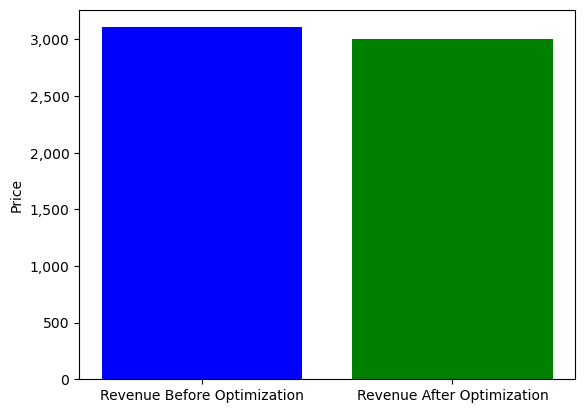

In [463]:
# Calculate revenue after optimization
revenue_after = np.mean(optimized_prices)
# Define revenue before and after optimization
revenue_values = [revenue_before, revenue_after]

# Print revenue before and after optimization
print("Revenue before optimization:", revenue_before)
print("Revenue after optimization:", revenue_after)


# Define labels for the bars
labels = ['Revenue Before Optimization', 'Revenue After Optimization']

# Plotting
plt.bar(labels, revenue_values, color=['blue', 'green'])
plt.ylabel('Price')
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

In [ ]:
def objective_function(prices,renewal):
    df_lote_otim["premio"]=prices
    renewal= model.predict(df_lote_otim)
    cost= df_lote_otim["Act_cost"]
    margem_esperada = renewal * (prices-cost)
    #penality = df_lote_otim.shape[0]*((np.mean(prob_esp) - renewal)**2)
    margem = -np.sum(margem_esperada)
    return margemdf_lote_otim

In [487]:
# Escorar o modelo
df_test = df_lote_otim
df_test['probabilidade_compra'] = model.predict(df_test)

In [492]:
# Função de margem esperada
def margem_esperada(probabilidade, premio, custo, preco_venda):
    return probabilidade * (preco_venda - custo) - (1 - probabilidade) * custo

# Função para otimização da margem esperada usando Lagrange 
def otimizar_margem(df_test):
    probabilidade = df_test['probabilidade_compra']
    premio = df_test['premio']
    custo = df_test['Act_cost']

    def objetivo(preco_venda):
        return -margem_esperada(probabilidade, premio, custo, preco_venda)

    resultado = minimize(objetivo,
                         x0=premio, 
                         bounds=[(custo, 2*premio)])
    return resultado.x[0]

# Otimizar a margem esperada para cada cliente
df_test['preco_otimizado'] = df_test.apply(otimizar_margem, axis=1)



PatsyError: predict requires that you use a DataFrame when predicting from a model
that was created using the formula api.

The original error message returned by patsy is:
Error evaluating factor: TypeError: loop of ufunc does not support argument 0 of type float which has no callable log method
    ind_renovacao ~ 1 + np.log(premio) + np.divide(premio, is_casco_ofer) + np.log(np.divide(premio, GBM_mercado)) + np.log(np.divide(premio, Premio_IC100)) + (np.divide(premio, premio_anterior)+1) + C(canal_bin,Treatment(reference="Demais")) + C(Cod_End_bin,Treatment(reference="Demais")) + C(fator_ajuste_bin,Treatment(reference="<101")) + per_com + C(per_com_bin,Treatment(reference=">=10")) + np.log(MD_tempo_casa_2+1) + C(idade_ult_RNS_bin,Treatment(reference="Sem Sinistro")) + C(MD_comb_bin,Treatment(reference="Demais")) + C(UF_bin,Treatment(reference="Demais")) + C(fx_ir_12m_bin,Treatment(reference="02 - 20-<=040")) + C(MD_tipo_renov,Treatment(reference="2 - Renov MAPFRE sem sinistro"))
                        ^^^^^^^^^^^^^^

In [490]:

# Exibir o dataframe resultante
df_test.head(5)

,Act_cost,Amostra,Amostra_inicial,ano_fab,ano_modelo,batente_max_ti,batente_min_ti,canal,Carprice,chave,...,idade_ult_RNS_bin,UF_bin,md_tipo_renov_ant_bin,Cod_End_bin,MD_capac_bin,fator_ajuste_bin,MD_qtd_assis_cpf_bin,prob_est,probabilidade_compra,preco_otimizado
5,1487.881781,Otimização Atu,Otimização Atu,2017,2017,2.3,0.6,BancoVotorantim,70221,231100010863100001,...,Sem Sinistro,"MT,PR",2-RenovPropria,Demais,Demais,<101,00,0.255946,0.255879,4025.925666
15,273.190374,Otimização Atu,Otimização Atu,2007,2008,2.3,0.6,Corretor,30080,10708289513100001,...,Sem Sinistro,"AP,DF,ES,PA,PB,RN,SC",2-RenovPropria,Demais,Demais,<101,00,0.745265,0.744068,876.397649
17,293.558516,Otimização Atu,Otimização Atu,2013,2014,2.3,0.6,GCdoBrasil,39263,50200046043100001,...,Sem Sinistro,Demais,2-RenovPropria,Demais,Demais,<101,00,0.653046,0.652141,1022.618499
20,251.381741,Otimização Atu,Otimização Atu,2013,2014,2.3,0.6,SicoobCopercana,33612,241100125133100001,...,Sem Sinistro,Demais,2-RenovPropria,Demais,Demais,<101,00,0.864104,0.863369,1061.113748
38,275.377276,Otimização Atu,Otimização Atu,2000,2000,2.3,0.6,CorretorMais,10863,228100912763100001,...,Sem Sinistro,Demais,2-RenovPropria,Demais,Demais,<101,00,0.939407,0.938838,884.651903


#criando a função

In [505]:
def categorizar(df):
    
    df['MD_sexo_bin'] = df['MD_sexo'].map({'Masculino': 'Masculino', 
                                 'Feminino': 'Feminino', 
                                  'ERRO': 'Masculino'}).astype(object)


    df['fx_ir_12m_bin'] = df['fx_ir_12m'].apply(lambda x: '01 - 00-<=020' if x == '01 - 00-<=020' else
                                                              '02 - 20-<=040' if x == '02 - 20-<=040' else
                                                              '03 - 40-<=060' if x == '03 - 40-<=060' else
                                                              '04 - 60-<=080' if x == '04 - 60-<=080' else
                                                              '05 - 80-<=100' if x == '05 - 80-<=100' else
                                                              '02 - 20-<=040' if x == 'NI'           else 'ERROR')

  
    df['MD_comb_bin'] = df['MD_comb'].apply(lambda x: 'Gasolina' if x == 'Gasolina'  else 'Demais')

    df['canal_bin'] =  df['canal'].apply(lambda x: 'Corretor Mais' if x == 'Corretor Mais'  else 'Demais')
   
    df['per_com_bin'] = df['per_com'].apply(lambda x: '<10' if x < 10 else
                                                          '>=10' if x >= 10 else 'ERROR')    



    df['idade_ult_RNS_bin'] = df['idade_ult_RNS'].apply(lambda x: 'Sem Sinistro' if x == 'Sem Sinistro' else
                                                                      '01 ano' if x == '01 ano' else
                                                                      '02 ano' if x == '02 ano' else '02 ano +')




    df['UF_bin'] = df['UF'].apply(lambda x: 'AL,CE,RS'  if x == 'AL' else
                                                'AL,CE,RS'  if x == 'CE' else
                                                'AL,CE,RS'  if x == 'RS' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'AP' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'DF' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'ES' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PA' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'PB' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'RN' else 
                                                'AP,DF,ES,PA,PB,RN,SC' if x == 'SC' else 
                                                'GO,MA,MG'             if x == 'GO' else 
                                                'GO,MA,MG'             if x == 'MA' else 
                                                'GO,MA,MG'             if x == 'MG' else 
                                                'MT,PR'                if x == 'MT' else
                                                'MT,PR'                if x == 'PR' else 
                                                'RJ'                   if x == 'RJ' else  'Demais')

    df['md_tipo_renov_ant_bin'] = df['Renovacao_ant'].apply(lambda x: '1-SeguroNovo'                      if x == '1-Seguro Novo'    else
                                                                          '2 - Renov MAPFRE sem sinistro'     if x == '2-RenovPropria'   else
                                                                          '3 - Renov MAPFRE com sinistro'     if x == '2-RenovPropria'   else
                                                                          '4 - Renov Congenere sem sinistro'  if x == '3-RenovCongenere' else
                                                                          '5 - Renov Congenere com sinistro'  if x == '3-RenovCongenere' else
                                                                          '6 - Renov BB sem sinistro'         if x == '3-RenovCongenere' else
                                                                          '7 - Renov BB com sinistro'         if x == '3-RenovCongenere' else  '2-RenovPropria')
      
     
    df['Cod_End_bin'] = df['Cod_End'].apply(lambda x: '13509'  if x == 13509 else
                                                          '13509'  if x == 50007 else
                                                          '13509'  if x == 50100 else 'Demais')   

    df['MD_capac_bin'] = df['MD_capac'].apply(lambda x: '5'  if x == 5  else 'Demais')  



    df['fator_ajuste_bin'] = df['MD_fator_ajuste'].apply(lambda x: '<101'    if x < 101 else
                                                                       '>=101'   if x >= 101  else '<101')   

    df['MD_qtd_assis_cpf_bin'] = df['MD_qtd_assis_cpf'].apply(lambda x: '00'  if x == 0 else
                                                                            '01'  if x == 1 else
                                                                            '>=2' if x >= 2 else 'ERROR')
    return df

In [506]:
df_mod_categ=df_mod_filtered.copy()

In [507]:
df_mod_categ = categorizar(df_mod_categ)

In [508]:
df_mod_categ.columns.to_list()

['premio_ofertado',
 'premio_total',
 'GBM_mercado',
 'premio_creserva',
 'premio_demais_cob',
 'teste_validacao',
 'ind_renovacao',
 'classe_bonus',
 'MD_sexo',
 'cod_corr',
 'Cod_End',
 'MD_sin_5a_cas',
 'MD_tempo_casa_2',
 'MD_idade_veic',
 'MD_faixa_IScas',
 'anomes_dt_ter',
 'MD_idade',
 'per_com',
 'RNS_Casco_calc',
 'MD_menor26',
 'UF',
 'Renovacao_ant',
 'fx_ir_12m',
 'is_casco_ofer',
 'classe_bonus',
 'MD_fator_ajuste',
 'MD_capac',
 'md_categoria',
 'MD_comb',
 'MD_qtd_assis_cpf',
 'idade_ult_RNS',
 'canal',
 'MD_tipo_renov',
 'FABRICA',
 'MD_est_civil',
 'peso',
 'Grupo_veiculo_new',
 'vigencia',
 'Risco_PP_mod',
 'Risco_PT_mod',
 'Risco_RF_mod',
 'Risco_DM_mod',
 'Risco_AS_mod',
 'Risco_DC_mod',
 'Risco_DMO_mod',
 'DA_emissao',
 'DA_producao',
 'risco_dmais_cob',
 'premio_anterior',
 'Act_cost',
 'Premio_IC100',
 'premio',
 'MD_sexo_bin',
 'fx_ir_12m_bin',
 'MD_comb_bin',
 'canal_bin',
 'per_com_bin',
 'idade_ult_RNS_bin',
 'UF_bin',
 'md_tipo_renov_ant_bin',
 'Cod_End_bin'